<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/branch_updates/VRAE_GRU_Green_mobility_210421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
!pip3 install pickle5

In [2]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix, roc_auc_score

import pickle5 as pickle

In [3]:

#Green mobility data
path = '/content/drive/MyDrive/AdvancedML/data/aligned_GM-5683_DRD-e9efaba7-a322-4793-a019-9592fb3ee73f_IRI.pickle'
with open(path, "rb") as fh:
  data = pickle.load(fh)

In [4]:
train_data = data[['acc.xyz.z','IRI']]
train_data_unstack = train_data.iloc[:,0].apply(list).apply(pd.Series)
frames = pd.concat([train_data,train_data_unstack],axis=1)
frames = frames.drop(labels = 'acc.xyz.z', axis=1)

In [144]:
def get_null(frames):
    r,c = frames.shape
    fig, ax = plt.subplots(figsize=(12,5))  
    sns.heatmap(frames.isnull(), ax=ax, cbar=False, cmap="Blues")
    ax.vlines(range(c), *ax.get_ylim(),linewidths=0.8,color='black')
    ax.axhline(y=0, color='k',linewidth=0.8)
    ax.axhline(y=(r-150), color='k',linewidth=0.8)
    ax.axvline(x=0, color='k',linewidth=0.8)
    ax.axvline(x=c, color='k',linewidth=2)
    plt.title('Visual inspection of missing values')
    plt.xlabel('Attribute columns')
    plt.ylabel('Row count')
    plt.show()
    

In [5]:
thresh = len(frames) * 0.95
frames.dropna(thresh = thresh, axis = 1, inplace = True)
frames = frames.dropna().reset_index(drop=True)

In [62]:
frames

,IRI,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.484676,1.00,1.00,0.98,0.95,0.94,0.98,0.96,0.92,0.91,1.00,0.92,0.91,0.95
1,1.046971,1.00,1.00,1.00,1.02,1.05,1.04,1.02,1.09,1.09,1.07,1.00,1.09,1.09
2,1.291508,0.94,0.88,0.88,0.93,0.93,1.02,1.02,1.03,1.03,0.97,0.97,0.95,0.95
3,4.076767,1.00,0.93,0.95,0.99,0.97,0.95,0.95,0.95,0.95,0.95,0.94,0.91,0.95
4,1.119708,0.98,0.96,0.98,0.98,0.97,0.93,0.96,0.98,0.93,0.94,0.93,0.93,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,0.616685,0.96,0.96,0.95,0.91,0.91,1.00,0.97,0.96,0.95,0.98,0.99,0.95,0.95
2282,0.924144,1.01,0.95,0.91,0.96,0.98,0.95,0.90,0.90,0.93,1.00,0.93,0.90,0.90
2283,0.868656,0.96,1.01,1.00,0.96,0.94,0.97,0.98,0.98,0.96,0.96,0.95,0.95,0.95
2284,0.851025,0.94,0.96,1.00,0.94,0.96,0.99,1.00,0.95,0.94,0.97,1.01,0.98,0.97


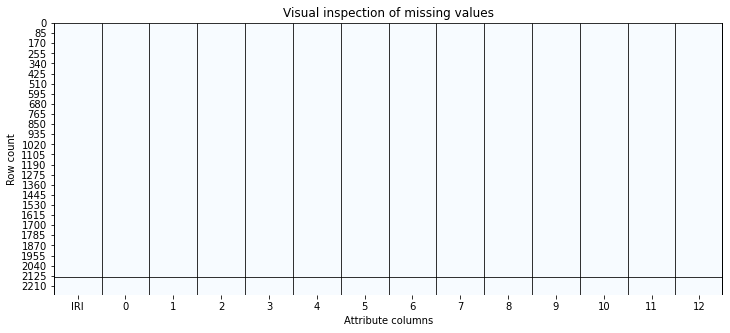

In [10]:
get_null(frames)

In [ ]:
frames = frames.iloc[:500,:25]

In [ ]:
frames = frames.fillna(0)

In [ ]:
frames

,IRI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2.484676,1.00,1.00,0.98,0.95,0.94,0.98,0.96,0.92,0.91,1.00,0.92,0.91,0.95,0.94,0.97,0.97,0.93,0.92,0.92,0.97,0.94,0.95,0.98,1.00
1,1.046971,1.00,1.00,1.00,1.02,1.05,1.04,1.02,1.09,1.09,1.07,1.00,1.09,1.09,1.02,0.84,0.82,0.95,0.95,0.84,0.84,0.73,0.73,0.80,0.80
2,1.291508,0.94,0.88,0.88,0.93,0.93,1.02,1.02,1.03,1.03,0.97,0.97,0.95,0.95,1.03,1.03,1.05,0.98,0.98,1.07,1.02,1.02,0.97,0.97,0.97
3,4.076767,1.00,0.93,0.95,0.99,0.97,0.95,0.95,0.95,0.95,0.95,0.94,0.91,0.95,0.95,0.93,0.93,0.96,0.93,0.96,0.00,0.00,0.00,0.00,0.00
4,1.119708,0.98,0.96,0.98,0.98,0.97,0.93,0.96,0.98,0.93,0.94,0.93,0.93,0.95,0.95,0.97,0.96,0.96,0.98,0.96,0.94,0.94,0.97,0.96,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.691803,0.95,0.96,0.98,0.98,0.94,0.93,0.93,0.93,0.92,0.88,0.85,0.90,0.90,0.92,0.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
496,1.320132,0.93,0.96,0.96,0.96,0.96,0.95,0.96,0.96,1.02,0.97,0.97,1.00,0.97,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
497,1.447124,0.96,0.99,0.99,0.98,0.97,1.00,0.98,0.96,0.95,0.97,0.97,0.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
498,1.422309,0.95,0.89,0.91,0.87,0.94,0.94,0.96,0.96,0.98,0.97,0.98,0.98,0.97,0.99,0.99,0.99,0.99,0.97,0.91,0.95,0.95,0.95,0.89,0.88


In [6]:
Normal = frames.loc[(frames['IRI'] <= 0.8)].drop(labels='IRI', axis=1).reset_index(drop=True)
Anomaly = frames.loc[(frames['IRI'] >=2)].drop(labels='IRI', axis=1).reset_index(drop=True)

In [7]:

normal_df = np.expand_dims(Normal,-1)
anomaly_df = np.expand_dims(Anomaly,-1)

In [279]:
normal_df.shape

(621, 13, 1)

In [280]:
anomaly_df.shape

(180, 13, 1)

In [8]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.33, random_state=RANDOM_SEED)
train_dataset = TensorDataset(torch.from_numpy(train_df).float())
test_dataset = TensorDataset(torch.from_numpy(test_df).float())
val_dataset = TensorDataset(torch.from_numpy(val_df).float())

#anomaly
anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())


In [9]:
seq_len = train_df.shape[1]
n_features = train_df.shape[2]

In [283]:
seq_len

13

In [10]:
cuda = torch.cuda.is_available()

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, pin_memory=cuda, drop_last=True)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
for i in test_loader:
  print(i[0].shape)

torch.Size([32, 13, 1])


In [14]:
class Encoder(nn.Module):

  def __init__(self, n_features, hidden_size, hidden_layer_depth, latent_length, bidirectional,dropout):

    super(Encoder,self).__init__()


    self.n_features = n_features
    self.hidden_size = hidden_size
    self.hidden_layer_depth = hidden_layer_depth
    self.latent_length = latent_length
    self.bidirectional = bidirectional
    self.direction_factor = (2 if self.bidirectional else 1)
    


    self.rnn1 = nn.GRU( input_size=self.n_features, 
                       hidden_size=self.hidden_size, 
                       dropout = dropout, 
                       num_layers = self.hidden_layer_depth,
                       batch_first=True,bidirectional = self.bidirectional)
      
  def forward(self, x):
    
    x = x.to(device)
    #print('input',x.shape)
    batch = x.size(0)
    h0 = torch.zeros(hidden_layer_depth*self.direction_factor, batch, self.hidden_size).to(device)

    out,hidden_n = self.rnn1(x,h0) 
    #print('hidden',hidden_n.shape)
    if self.bidirectional:

      last_hidden_state = hidden_n.view(hidden_layer_depth, self.direction_factor, batch, self.hidden_size)[-1] #(num_directions, batch, hidden_size)
      #print('final',last_hidden_state.shape)
      h_1, h_2 = last_hidden_state[0], last_hidden_state[1]
      #print('h1',h_1.shape)
      #print('h2',h_2.shape)

      #X = h_1 + h_2                # Add both states (needs different input size for first linear layer)
      hidden = torch.cat((h_1, h_2), 1)  # Concatenate both states
      #print('X',hidden.shape)
    else:
      hidden = hidden_n[-1, :, :]
      #print('cell',hidden.shape)
    

    return hidden



In [102]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
bidirectional = False

# encoder
en = Encoder(n_features, hidden_size, hidden_layer_depth, hidden_size, bidirectional, dropout).to(device)
en


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Encoder(
  (rnn1): GRU(1, 90, batch_first=True, dropout=0.2)
)

In [103]:
X= next(iter(train_loader))
x = X[0].to(device)
outputs = en(x.float())
cell = outputs

In [104]:
print('cell',cell.shape)


cell torch.Size([32, 90])


In [15]:
class Latent(nn.Module):
    """Lambda module converts output of encoder to latent vector
    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    """
    def __init__(self, hidden_size, latent_length,bidirectional):
        super(Latent, self).__init__()

        self.bidirectional = bidirectional
        self.direction_factor = (2 if self.bidirectional else 1)
        self.hidden_size = hidden_size
        self.latent_length = latent_length

        self.hidden_to_mean = nn.Linear(self.hidden_size*self.direction_factor, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size*self.direction_factor, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, cell_output):
        
        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)
        z_mu = self.latent_mean
        z_var = self.latent_logvar
        

        
        std = torch.exp(0.5 * self.latent_logvar)
        eps = torch.randn_like(std)
        sample = eps.mul(std).add_(self.latent_mean)

        return sample, z_mu, z_var
        

In [106]:
#latent
latent_length=20
bidirectional = False
la = Latent(hidden_size,latent_length,bidirectional).to(device)

In [107]:
sample,z_mu,z_var = la(cell)

In [108]:
print(sample.shape)
print(z_mu.shape)
print(z_var.shape)

torch.Size([32, 20])
torch.Size([32, 20])
torch.Size([32, 20])


In [16]:

class Decoder(nn.Module):

  def __init__(self, seq_len, batch_size, hidden_size, hidden_layer_depth, latent_length, n_features,bidirectional):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.hidden_layer_depth = hidden_layer_depth
    self.latent_length = latent_length
    self.n_features = n_features
    self.bidirectional = bidirectional
    self.direction_factor = (2 if self.bidirectional else 1)
    
    

    self.rnn1 = nn.GRU(input_size=1,
                       hidden_size=self.hidden_size,
                       dropout = dropout,
                       num_layers=hidden_layer_depth,
                       batch_first=True,
                       bidirectional= bidirectional
                       )

    

    self.latent_to_hidden = nn.Linear(self.latent_length,self.hidden_size)
    self.hidden_to_output = nn.Linear(self.hidden_size*self.direction_factor, self.n_features)

    self.decoder_inputs = torch.zeros( self.batch_size, self.seq_len, 1, requires_grad=True).to(device)

    nn.init.xavier_uniform_(self.latent_to_hidden.weight)
    nn.init.xavier_uniform_(self.hidden_to_output.weight)


  def forward(self, x):
    #print('original',x.shape)
    x = x.to(device)
    h_state = self.latent_to_hidden(x)
    #print('h_state',h_state.shape)


    h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth*self.direction_factor)]).to(device)
    #print('h0',h_0.shape)

    
    d = self.decoder_inputs
    #print('input',d.shape)
    decoder_output, _ = self.rnn1(self.decoder_inputs, h_0)
    #print('decoder_output',decoder_output.shape)

    out = self.hidden_to_output(decoder_output)

    return out

In [17]:
class VAE(nn.Module):

  def __init__(self, enc,lat,dec):

    super(VAE,self).__init__()

  
    self.enc = enc
    self.lat = lat
    self.dec = dec
    

  def forward(self, x):

    encoder_output = self.enc(x)
    sample,z_mu,z_var = self.lat(encoder_output)
    x_hat = self.dec(sample)



    return x_hat, z_mu, z_var 

In [18]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 10
dropout = 0.2
bidirectional = True
# encoder
encoder = Encoder( n_features, hidden_size, hidden_layer_depth, latent_length,bidirectional, dropout)

#latent
latent = Latent( hidden_size, latent_length, bidirectional)

# decoder
decoder = Decoder(seq_len, batch_size, hidden_size, hidden_layer_depth, latent_length, n_features,bidirectional)

# vae
model = VAE(encoder,latent,decoder).to(device)



print(model)

VAE(
  (enc): Encoder(
    (rnn1): GRU(1, 90, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (lat): Latent(
    (hidden_to_mean): Linear(in_features=180, out_features=10, bias=True)
    (hidden_to_logvar): Linear(in_features=180, out_features=10, bias=True)
  )
  (dec): Decoder(
    (rnn1): GRU(1, 90, batch_first=True, dropout=0.2, bidirectional=True)
    (latent_to_hidden): Linear(in_features=10, out_features=90, bias=True)
    (hidden_to_output): Linear(in_features=180, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
def loss(X, x_hat, z_mu, z_var, beta, criterion):
  

  if criterion == 'MSELoss':
    criterion = nn.MSELoss(size_average=False)
  elif criterion == 'SmoothL1Loss':
    criterion = nn.SmoothL1Loss(size_average=False)

  recon_loss = criterion(x_hat, X)
  KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
  elbo_loss = recon_loss + beta * KL_loss
  
  return elbo_loss, KL_loss

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001) # lr derived from optimazation method

#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [21]:
X= next(iter(train_loader))
x = X[0].to(device)
outputs = model(x.float())


x_hat, z_mu, z_var = outputs

#total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, mu_rec, var_rec, z_sample,criterion='SmoothL1Loss')
print('x',x.shape)
print('mu',z_mu.shape)
print('var',z_var.shape)
print('x_hat',x_hat.shape)
# print('total',total_loss)
# print('elbo',elbo_loss)
# print('KL',KL_loss)


x torch.Size([32, 13, 1])
mu torch.Size([32, 10])
var torch.Size([32, 10])
x_hat torch.Size([32, 13, 1])


In [22]:
elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var,beta=150,criterion='SmoothL1Loss')

print(elbo_loss)
print(KL_loss)

tensor(263.3459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0097, device='cuda:0', grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
def train():
 

  model.train()

  train_loss = []
  train_kl = []
  
  

  for t, X in enumerate(train_loader):

    X =X[0]
    #print('trina',X.shape)
    X = X.to(device)

    optimizer.zero_grad()

    x_hat, z_mu, z_var= model(X)

    elbo_loss, KL_loss = loss(X, x_hat, z_mu, z_var, beta = 150,criterion='MSELoss')
    # total_loss = (len(train_loader)/X.shape[0])*total_loss
    # elbo_loss = (len(train_loader)/X.shape[0])*elbo_loss

    elbo_loss.backward()

    train_loss.append(elbo_loss.item())
    train_kl.append(KL_loss.item())
    

    optimizer.step()
  
  train_elbo_loss = np.mean(train_loss)
  train_kl_loss = np.mean(train_kl)
 

  return  train_elbo_loss,train_kl_loss

In [24]:
def test():

  model.eval()

  with torch.no_grad():
    test_loss = []
    test_kl = []
    
    for t, x in enumerate(val_loader):

      x = x[0]
      x = x.to(device)
      x_hat, z_mu, z_var = model(x)
      elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var,beta=150,criterion='SmoothL1Loss')
      # total_loss = (len(val_loader)/x.shape[0])*total_loss
      # elbo_loss = (len(val_loader)/x.shape[0])*elbo_loss

      test_loss.append(elbo_loss.item())
      test_kl.append(KL_loss.item())
      

  test_elbo_loss = np.mean(test_loss)
  test_kl_loss = np.mean(test_kl)
  

  return model.eval(), test_elbo_loss,test_kl_loss

In [25]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
epochs = 100

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
history_elbo = dict(train_elbo=[], test_elbo=[])
history_kl = dict(train_kl=[], test_kl=[])


device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for e in range(epochs):

  start_time = time.time()

  train_elbo_loss, train_kl_loss = train()
  model, test_elbo_loss, test_kl_loss  = test()

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if best_loss > test_elbo_loss:
    best_test_loss = test_elbo_loss
    best_model_wts = copy.deepcopy(model.state_dict())

  print(f'Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\t train elbo loss {train_elbo_loss}   | train kl loss {train_kl_loss}') 
  print(f'\t val  val elbo loss {test_elbo_loss} | valid kl loss {test_kl_loss}') 


  history_elbo['train_elbo'].append(train_elbo_loss)
  history_elbo['test_elbo'].append(test_elbo_loss)

  history_kl['train_kl'].append(train_kl_loss)
  history_kl['test_kl'].append(test_kl_loss)


Using device: cuda:0
Epoch: 01 | Epoch Time: 0m 0s
	 train elbo loss 480.16029930114746   | train kl loss 0.009028794767800719
	 val  val elbo loss 204.2730255126953 | valid kl loss 0.009319603443145752


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 02 | Epoch Time: 0m 0s
	 train elbo loss 364.296838760376   | train kl loss 0.011205983522813767
	 val  val elbo loss 155.557373046875 | valid kl loss 0.014198041521012783
Epoch: 03 | Epoch Time: 0m 0s
	 train elbo loss 269.89746952056885   | train kl loss 0.018277587601915002
	 val  val elbo loss 108.932861328125 | valid kl loss 0.023920904844999313
Epoch: 04 | Epoch Time: 0m 0s
	 train elbo loss 189.96285247802734   | train kl loss 0.03060729941353202
	 val  val elbo loss 77.91618347167969 | valid kl loss 0.03935030475258827
Epoch: 05 | Epoch Time: 0m 0s
	 train elbo loss 126.07018899917603   | train kl loss 0.04921571258455515
	 val  val elbo loss 51.51731872558594 | valid kl loss 0.061739709228277206
Epoch: 06 | Epoch Time: 0m 0s
	 train elbo loss 72.83642745018005   | train kl loss 0.07414409914053977
	 val  val elbo loss 31.46648597717285 | valid kl loss 0.08762460201978683
Epoch: 07 | Epoch Time: 0m 0s
	 train elbo loss 44.366875886917114   | train kl loss 0.0950379399582

In [27]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

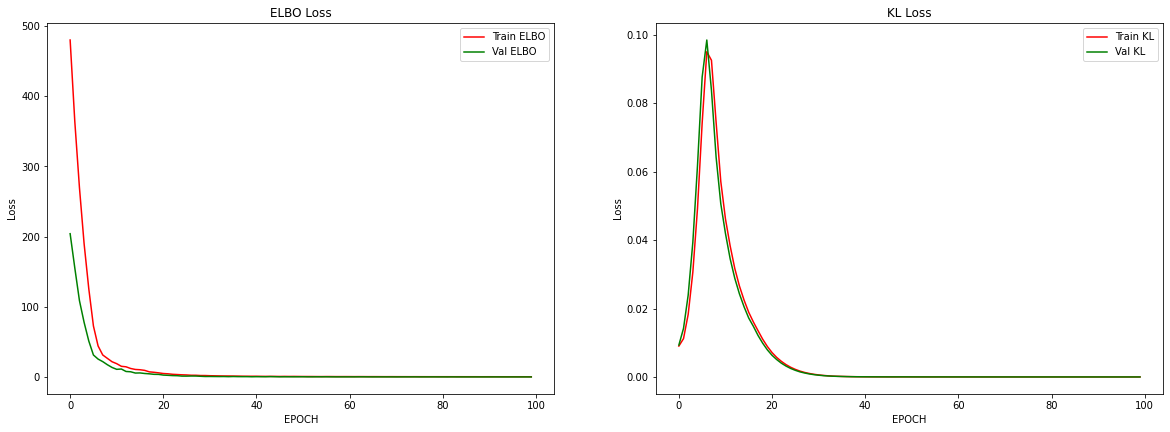

In [28]:
fig = plt.figure(figsize=(20,15))


fig.add_subplot(2,2,1)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['test_elbo']))), history_elbo['test_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')

fig.add_subplot(2,2, 2)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['test_kl']))), history_kl['test_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')





plt.show();



In [29]:
def predict(model, dataset):
    predictions = []
    with torch.no_grad():
        model = model.eval()
    for t, X in enumerate(dataset):
        X = X[0]
        x = X.to(device)
        #x = Variable(x, requires_grad = False)
        x_hat, z_mu, z_var = model(x)
        x_hat = x_hat.cpu().detach().numpy()
        x_hat = np.squeeze(x_hat, axis=2)
        predictions.append(x_hat)
    predictions = np.concatenate(predictions, axis=0, out= None)
    return predictions

In [30]:
predict_train = predict(model, train_loader)

In [31]:
predict_train.shape

(512, 13)

In [32]:
train_df = train_df[:512]
train_original = np.squeeze(train_df,axis=2)

In [33]:
train_original.shape

(512, 13)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


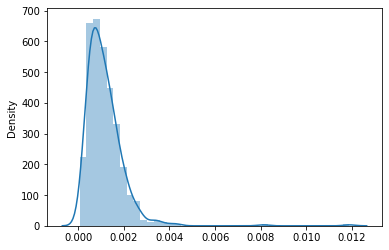

In [34]:
train_sq_loss = np.mean(( train_original- predict_train)**2, axis=1)
sns.distplot(train_sq_loss, bins=40, kde=True)
plt.show()

In [35]:
predict_test = predict(model, test_loader)
predict_test.shape

(32, 13)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


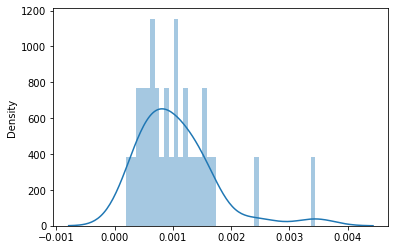

In [36]:
test_df=test_df[:32]
test_original = np.squeeze(test_df,axis=2)
test_sq_loss = np.mean(( test_original- predict_test)**2, axis=1)
sns.distplot(test_sq_loss, bins=40, kde=True)
plt.show()

In [37]:

# anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())
# anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
predict_anomaly = predict(model, anomaly_loader)

In [38]:
predict_anomaly.shape

(160, 13)

In [39]:
anomaly_df = anomaly_df[:160]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


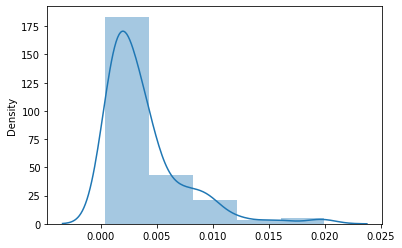

In [40]:
anomaly_sq_loss = np.mean(( np.squeeze(anomaly_df) - predict_anomaly)**2, axis=1)
sns.distplot(anomaly_sq_loss, bins=5, kde=True)
plt.show()

In [42]:
threshold_fixed = 0.003

In [48]:
def plot_prediction(data, reconstructed, title, ax):
  ax.plot(data,'r', label='true')
  ax.plot(reconstructed, 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(np.mean(( data- reconstructed)**2), 2)})')
  ax.legend()

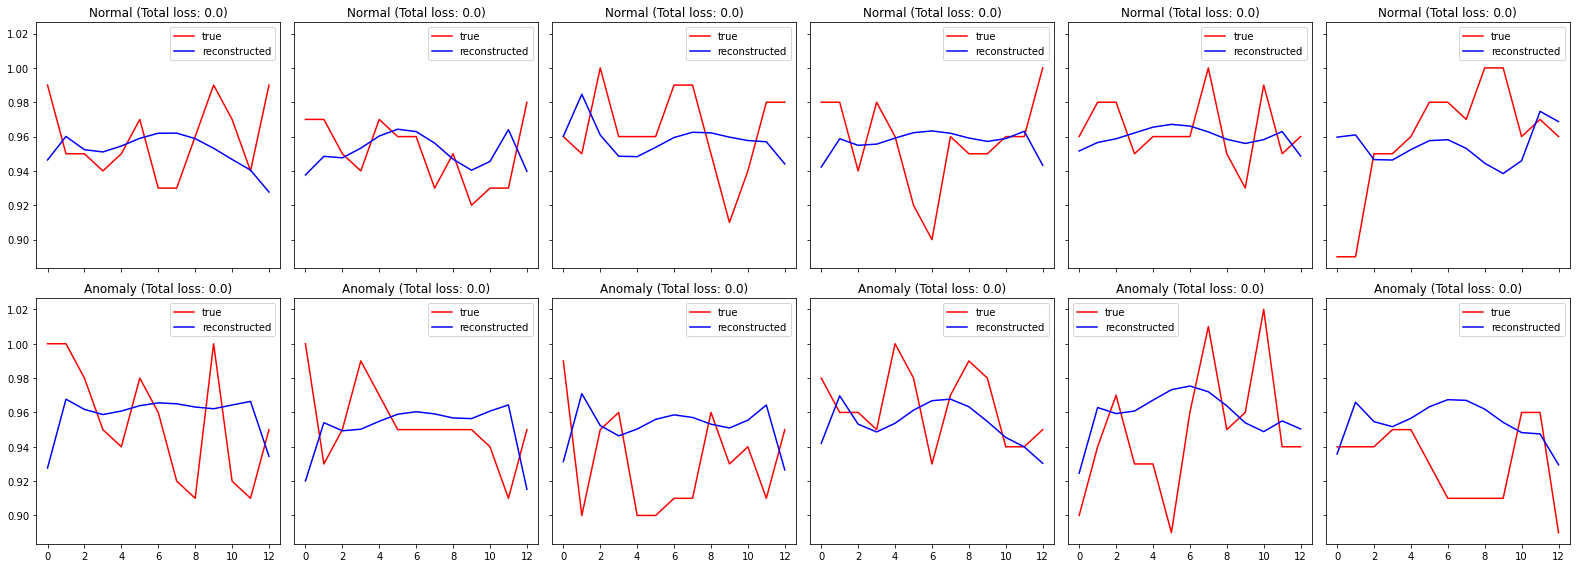

In [49]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_original[:6]):
  plot_prediction(data, predict_test[i], title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly_df[:6]):
  plot_prediction(data, predict_anomaly[i], title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [50]:
len(anomaly_sq_loss)

160

In [51]:
label = np.concatenate((np.ones(len(test_sq_loss)),np.zeros(len(test_sq_loss))))
#total_losses = np.concatenate((train_sq_loss,anomaly_sq_loss),axis=0)
total_losses = np.concatenate((test_sq_loss,np.random.choice(anomaly_sq_loss, len(test_sq_loss),replace=True)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(2)

,Reconstruction_error,Label
0,0.000777,1.0
1,0.000457,1.0


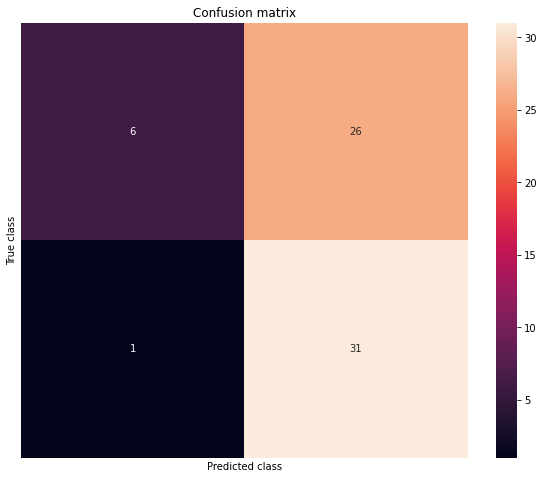

In [52]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [53]:
TN = conf_matrix[0][0]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
FP = conf_matrix[0][1]

In [54]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('Precision',precision)
print('Recall',recall)

Precision 0.543859649122807
Recall 0.96875


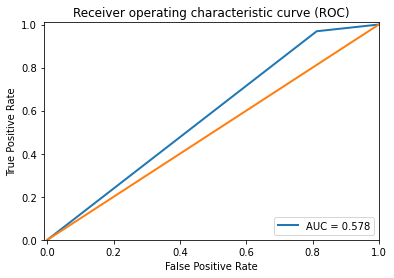

In [55]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()